In [33]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import tqdm
import numpy as np
import utils
import dataloaders
import torchvision
from trainer import Trainer
torch.random.manual_seed(0)
np.random.seed(0)

### Dataset

In [34]:
# Load the dataset and print some stats
batch_size = 64

image_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32, 32)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.5], [0.5])])

dataloader_train, dataloader_test = dataloaders.load_dataset(batch_size, image_transform)
example_images, _ = next(iter(dataloader_train))
print(f"The tensor containing the images has shape: {example_images.shape} (batch size, number of color channels, height, width)",
      f"The maximum value in the image is {example_images.max()}, minimum: {example_images.min()}", sep="\n\t")

The tensor containing the images has shape: torch.Size([64, 1, 32, 32]) (batch size, number of color channels, height, width)
	The maximum value in the image is 1.0, minimum: -1.0


In [41]:
def create_model():
    """
        Initializes the mode. Edit the code below if you would like to change the model.
    """
    model = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        nn.Flatten(),
        nn.Linear(128*16, 64),
        nn.ReLU(),
        nn.Linear(64, 10),
        nn.ReLU(),
        # nn.Flatten(), # Flattens the image from shape (batch_size, C, Height, width) to (batch_size, C*height*width)
        # nn.Linear(32*32*1, 10)
        # No need t
        # o include softmax, as this is already combined in the loss function
    )

    # pool = nn.MaxPool2d(2, stride=2, padding=0)
    # conv_layer_1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2)
    # model.add_module("Conv1", conv_layer_1)
    # model.add_module("Pool1", pool)
    # conv_layer_2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
    # model.add_module("Conv2", conv_layer_2)
    # model.add_module("Pool2", pool)
    # conv_layer_3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
    # model.add_module("Conv3", conv_layer_3)
    # model.add_module("Pool3", pool)
    # flatten = nn.Flatten()
    # model.add_module("Flatten", flatten)
    # model.add_module("Linear1", nn.Linear(128*16, 64))
    # model.add_module("Hidden1", nn.ReLU())
    # model.add_module("Linear2", nn.Linear(64, 10))
    # model.add_module("Hidden2", nn.ReLU())

    # Transfer model to GPU memory if a GPU is available
    model = utils.to_cuda(model)
    return model


model = create_model()

adam_model = create_model()

In [42]:
# Test if the model is able to do a single forward pass
example_images = utils.to_cuda(example_images)
print(example_images.shape)
output = model(example_images)
print("Output shape:", output.shape)
expected_shape = (batch_size, 10) # 10 since mnist has 10 different classes
assert output.shape == expected_shape,    f"Expected shape: {expected_shape}, but got: {output.shape}"

torch.Size([64, 1, 32, 32])
Output shape: torch.Size([64, 10])


### Hyperparameters & Loss function

In [43]:
# Hyperparameters
learning_rate_SGD = .02
learning_rate_adam = .001
num_epochs = 5


# Use CrossEntropyLoss for multi-class classification
loss_function = torch.nn.CrossEntropyLoss()

# Define optimizer (Stochastic Gradient Descent)
optimizer_sgd = torch.optim.SGD(model.parameters(),
                            lr=learning_rate_SGD)

# Define optimizer (Adam)
optimizer_adam = torch.optim.Adam(model.parameters(),
                            lr=learning_rate_adam)


### Train model

In [44]:
# SGD optimized
trainer_sgd = Trainer(
  model=model,
  dataloader_train=dataloader_train,
  dataloader_test=dataloader_test,
  batch_size=batch_size,
  loss_function=loss_function,
  optimizer=optimizer_sgd
)
train_loss_dict_sgd, test_loss_dict_sgd = trainer_sgd.train(num_epochs)

# Adam optimized
trainer_adam = Trainer(
  model=model,
  dataloader_train=dataloader_train,
  dataloader_test=dataloader_test,
  batch_size=batch_size,
  loss_function=loss_function,
  optimizer=optimizer_adam
)
train_loss_dict_adam, test_loss_dict_adam = trainer_adam.train(num_epochs)

Training epoch 4: 100%|██████████| 937/937 [00:14<00:00, 64.31it/s]


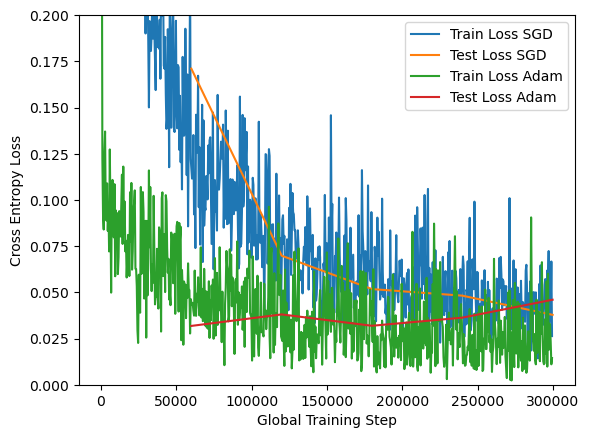

Final Test loss SGD: 0.04599187189185275. Final Test accuracy SGD: 0.9871
Final Test loss Adam: 2.302149532706874. Final Test accuracy Adam: 0.0979


In [59]:
# We can now plot the training loss with our utility script

# Plot loss sgd
utils.plot_loss(train_loss_dict_sgd, label="Train Loss SGD")
utils.plot_loss(test_loss_dict_sgd, label="Test Loss SGD")

# Plot loss adam
utils.plot_loss(train_loss_dict_adam, label="Train Loss Adam")
utils.plot_loss(test_loss_dict_adam, label="Test Loss Adam")

# Limit the y-axis of the plot (The range should not be increased!)
plt.ylim([0, .2])
plt.legend()
plt.xlabel("Global Training Step")
plt.ylabel("Cross Entropy Loss")
# plt.savefig(utils.image_output_dir.joinpath("task2b_plot.png"))
plt.show()

final_loss, final_acc = utils.compute_loss_and_accuracy(
    dataloader_test, model, loss_function)
print(f"Final Test loss SGD: {final_loss}. Final Test accuracy SGD: {final_acc}")

final_loss, final_acc = utils.compute_loss_and_accuracy(
    dataloader_test, adam_model, loss_function)
print(f"Final Test loss Adam: {final_loss}. Final Test accuracy Adam: {final_acc}")

Final Test loss SGD: 0.04599187189185275. Final Test accuracy SGD: 0.9871
I can see there is a quite high variance compared to the model performance. Hence it seems like the network is a little overfitted.